In [4]:

# %%
import os
import glob
import copy
import sys
import pickle 
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np 


# from rslds_visualization_utils import plot_states_and_neurons, plot_states_and_neurons_state_list
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import LinearSegmentedColormap

sys.path.append("/Users/friederikebuck/Desktop/MBL/project/WholeBrainImagingAnalysis/collab/")
sys.path.append('/Users/bennetsakelaris/Documents/Obsidian Vault/Worms/wormcode/Code+Notes 09-24-24/collab/')

sys.path.append("/Users/friederikebuck/Downloads/worm notes/worm_code/")


# from get_data.read_neuro_beh_data import get_exp_features, load_json
# from get_data.process_neural_data import get_derivative_of_neural_activity, get_neural_activity_from_labels, get_neural_activity_and_labels
# from beh_classification.behavior_features import get_behavior_features
# from get_data.read_neuro_beh_data import get_exp_features, load_json

# from beh_classification.process_midlines.midline_utils import save_as_csv, load_from_csv, convert_coordinates_to_angles
# from rslds_motor_state_class_fncs import get_motor_state_start_end_is_rslds_start_end_specific

from load_data_fncs import load_all_data, get_exp_dates

# from plotting_utils import plot_probabilities_hist, plot_hist_across_conditins_and_get_KS_stats
# from categorize_reor_fncs import find_runs, make_masks, get_reor_mat, get_zero_crossing_indices, count_zero_crossing, get_date_to_state_bin, get_all_states_bin
# from visualize_state_fncs import get_motor_state_start_end_is_rslds_start_end_specific_1, get_features_from_track_start_end_is, remove_nans, visualize_transition_matrix, get_rslds_pair_counts, plot_feature_hists_motor_states, get_pair_wise_avgs, plot_neural_activity_heatmap, plot_neural_activity
    

T = 1599

motor_state_num_to_name = {
    0:"fwd", 
    1:"rev", 
    2:"turn", 
    3:"pure rev", 
    4:"rev of rev turn", 
    5:"turn of rev turn", 
    6:"pure turn"
}
rslds_state_num_to_name = {
    0:"fwd-like", 
    1:"rev-like", 
    2:"turn-like", 
    3:"pure rev", 
    4:"rev of rev turn", 
    5:"turn of rev turn", 
    6:"pure turn"
}

rslds_state_to_color = {
    0: "salmon", 
    1: "dodgerblue", 
    2: "green"
}


comp = "mac"
if comp == "hpc":
  project_dir = "/ru-auth/local/home/fbuck/scratch/WholeBrainImaging/keypt_moseq/projects/_1/"#sys.argv[1]+"_1"#/Volumes/FB1/moseq_project_dir/WholeBrainImagingAnalysis_1/"
  video_dir = "/ru-auth/local/home/fbuck/scratch/WholeBrainImaging/outputs_hpc/" #"/Users/friederikebuck/Desktop/MBL/project/outputs/"  #when al subdirs with vids or keypoints are stored 
  video_clip_dir = "/ru-auth/local/home/fbuck/scratch/WholeBrainImaging/outputs_hpc/vid_clips/"

else: 
#   project_dir = "/Volumes/FB1/moseq_project_dir_and_outputs/_1/"
# moseq_project_dir = ""
    project_dir = "/Volumes/FB1/moseq_project_dir_and_outputs/_1/"
    project_dir = "/Volumes/FB_data_ana/moseq_project_dir_and_outputs/_1/"
    video_dir = "/Users/friederikebuck/Desktop/MBL/project/outputs/" #"/Users/friederikebuck/Desktop/MBL/project/outputs/"  #when al subdirs with vids or keypoints are stored 
    video_clip_dir = "/Users/friederikebuck/Desktop/MBL/project/vid_clips/"
    save_dir = f"/Volumes/FB_data_ana/moseq_project_dir_and_outputs_figs/"

    # os.makedirs(save_dir, exist_ok=True)

json_dir = "/Users/friederikebuck/Desktop/MBL/project/data/Neuropal_no_heat/"
h5_dir ="/Users/friederikebuck/Desktop/MBL/project/data/processed_h5/"
beh_data_dir_parent = "/Users/friederikebuck/Desktop/MBL/project/outputs/"
        
full_traces, full_neural_labels, full_beh_classification, full_beh_data = load_all_data()
velocity_og = np.array([full_beh_data[i]["velocity"][0:1599] for i in range(len(full_beh_data))])
acceleration_og = np.array([full_beh_data[i]["acceleration"][1:1600] for i in range(len(full_beh_data))])
head_curvature_og = np.array([full_beh_data[i]["head_angle"][0:1599] for i in range(len(full_beh_data))])
worm_curvature_og = np.array([full_beh_data[i]["worm_curvature"][0:1599] for i in range(len(full_beh_data))])
pumping_og = np.array([full_beh_data[i]["pumping"][0:1599] for i in range(len(full_beh_data))])
body_angle_mag_og = np.array([full_beh_data[i]["body_angle_mag"][0:1599] for i in range(len(full_beh_data))])
midlines_og =  np.array([full_beh_data[i]["midlines"][0:1599] for i in range(len(full_beh_data))])
body_angles_og =  np.array([full_beh_data[i]["body_angles"][0:1599] for i in range(len(full_beh_data))])

velocity = copy.deepcopy(velocity_og)
acceleration = copy.deepcopy(acceleration_og)
head_curvature = copy.deepcopy(head_curvature_og)
worm_curvature = copy.deepcopy(worm_curvature_og)
pumping = copy.deepcopy(pumping_og)
body_angle_mag =copy.deepcopy(body_angle_mag_og)
midlines =copy.deepcopy( midlines_og)
body_angles = copy.deepcopy(body_angles_og)

pdf_save_dir = "/Users/friederikebuck/Downloads/worm notes/rslds_all_dates/"
os.makedirs(pdf_save_dir, exist_ok=True)
directories = glob.glob(json_dir+"*.json") #get filename/paths of all the json files
exp_dates = [directory.split("/")[-1].split(".")[0] for directory in directories] #extract the exp_dates
# exp_date_to_jpeg_dir = {exp_date: exp_to_jpeg_dir(exp_date) for exp_date in exp_dates} ###for not wusing 10sx eesmapled..s hould use confocal..? go from rslds to 20 

   
kappas = np.logspace(3,7,5)
kappas = [kappas[0]]
decrease_kappa_factor = 10
num_ar_iters = 50
num_full_iters = 200
time_bin = 10
prefix = 'my_kappa_scan'
# for kappa in kappas: #kappas[:2]
kappa = kappas[0]
print(f"Fitting model with kappa={kappa}")
model_name = f'{prefix}-{kappa}'
# fig_save_dir = os.path.join(save_dir, model_name)

np.random.seed(0)

foldername = "/Users/friederikebuck/Downloads/worm notes/processed_checkpts/test_rslds_QM_run_061325/model_selection/top_2_combined/"
items = np.array(os.listdir(foldername))
folders = np.array(["." not in directory for directory in items], dtype=bool)
folders = items[folders]

folder = folders[0]


with open(foldername+"/Y.npy", 'rb') as handle:  
    Y = pickle.load(handle)


with open(foldername+folder+"/saved_data/prior.npy", 'rb') as handle:
    global_worm = pickle.load(handle)
    global_worm.D = int(global_worm.D)

with open(foldername+folder+"/saved_data/prior_q.npy", 'rb') as handle:
    q = pickle.load(handle)
    

slds = global_worm

neural_labels = np.load(foldername+"/neurons.npy", allow_pickle=True)


print(np.array(Y).shape)

print(len(neural_labels))



slds = global_worm
# get estimated latents, states
q_x = q.mean_continuous_states
q_z = [slds.most_likely_states(q_x[w], Y[w]) for w in range(len(q_x))]

z = [beh_classification["is_fwd"][0:1599]+ 2*beh_classification["is_rev"][0:1599]+ 4*beh_classification["is_pause"][0:1599]+3*beh_classification["is_turn"][0:1599]-1 for beh_classification in full_beh_classification]
q_z= np.array(q_z)
print(q_z.shape)
z = np.array(z)
print(z.shape)

Worm 0, date: 2022-06-14-01
Worm 1, date: 2023-01-23-08
Worm 2, date: 2022-06-28-07
Worm 3, date: 2022-07-15-12
Worm 4, date: 2023-01-19-01
Worm 5, date: 2022-08-02-01
Worm 6, date: 2022-06-14-07
Worm 7, date: 2022-06-28-01
Worm 8, date: 2023-01-23-15
Worm 9, date: 2022-07-26-01
Worm 10, date: 2023-01-19-15
Worm 11, date: 2023-03-07-01
Worm 12, date: 2022-06-14-13
Worm 13, date: 2023-01-23-21
Worm 14, date: 2023-01-19-22
Worm 15, date: 2023-01-23-01
Worm 16, date: 2023-01-17-01
Worm 17, date: 2022-07-20-01
Worm 18, date: 2023-01-09-28
Worm 19, date: 2023-01-19-08
Worm 20, date: 2022-07-15-06


/Users/friederikebuck/Desktop/MBL/project/WholeBrainImagingAnalysis/collab/beh_classification/behavior_features.py:11: RuntimeWarning: Mean of empty slice
  body_angles = body_angles-np.nanmean(body_angles, axis = 1)[:, None]
/Users/friederikebuck/Desktop/MBL/project/WholeBrainImagingAnalysis/collab/beh_classification/behavior_features.py:15: RuntimeWarning: Mean of empty slice
  centroids = np.nanmean(midlines, axis = 1)


Fitting model with kappa=1000.0
(21, 1599, 138)
138
(21, 1599)
(21, 1599)


neural_activity_aligned_feature.shape (68, 20, 138)
rev_start_aligned_feature.shape (68, 20)


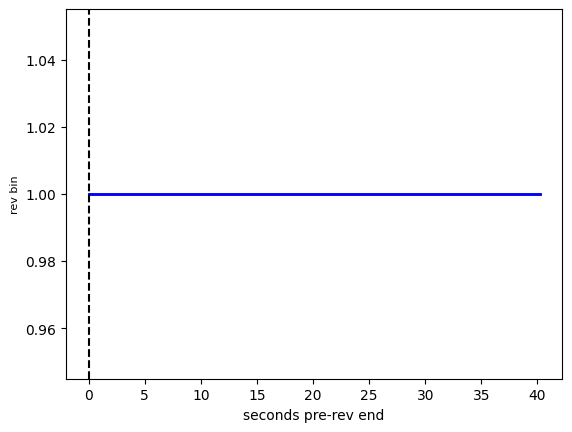

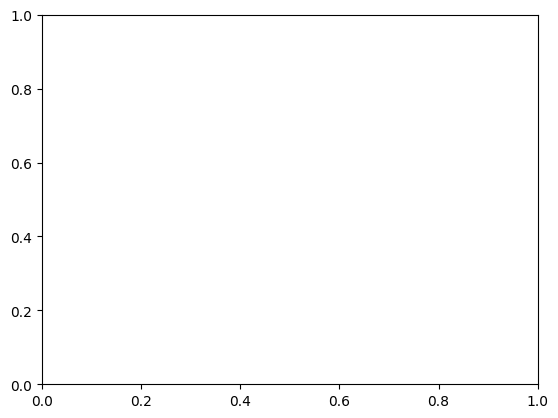

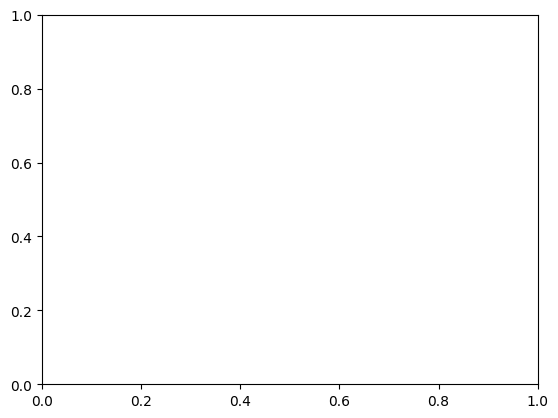

In [2]:
import numpy as np
####seperate rev turn and pure turn 
#get start end i of rev turn
from categorize_reor_fncs import find_runs, make_masks, get_reor_mat, get_zero_crossing_indices, count_zero_crossing, get_date_to_state_bin, get_all_states_bin
from categorize_reor_fncs import get_state_start_ends, get_state_to_track_start_end_is
from spont_rev_prediction_fncs import plot_mean_line_graph_with_individ_traces


# n_pre_frames = 0
# dt = 0.6
# fig, ax1 = plt.subplots()
# feature_lbl = "rev bin"
# rev_duration_min_frames = 20
# rev_of_rev_turn_to_track_start_end_is = get_state_to_track_start_end_is(rev_of_rev_turn_bin_mat, states = [1])[1]

# rev_end_aligned_feature = align_feature_to_rev_end_from_start_end_is(rev_of_rev_turn_bin_mat,
#                                                                      rev_of_rev_turn_to_track_start_end_is, 
#                                                                      max_prior_frames,
                            
#                             rev_duration_min_frames = rev_duration_min_frames, rev_duration_max_frames = np.inf
#     )




# plot_mean_line_graph_with_individ_traces(rev_end_aligned_feature.T, n_pre_frames, fps = 1/dt,  fig = fig, ax =ax1 , seconds = None, 
#                                             title = f"", 
#                                             xlabel ="seconds pre-rev end", 
#                                             ylabel =f"{feature_lbl}", color = "blue", ylim =None,  ylabel_font_size = 8, 
#                                             max_n_tracks = 30,line_width=1.0, 
                                            
#                                             )#### this shoudl all just be 1 

# ##try with turn of rev turn ; pure rev etc and should all be 0 
# ##try with extended end 



# fig, ax1 = plt.subplots()
# feature_lbl = "curvature"
# rev_end_aligned_feature = align_feature_to_rev_end_from_start_end_is(worm_curvature_og,
#                                                                      rev_of_rev_turn_to_track_start_end_is, 
#                                                                      max_prior_frames,
                            
#                             rev_duration_min_frames = rev_duration_min_frames, rev_duration_max_frames = np.inf
#     )





# plot_mean_line_graph_with_individ_traces(rev_end_aligned_feature, n_pre_frames, fps = 1/dt,  fig = fig, ax =ax1 , seconds = None, 
#                                             title = f"", 
#                                             xlabel ="seconds pre-rev end", 
#                                             ylabel =f"{feature_lbl}", color = "blue", ylim =None,  ylabel_font_size = 8, 
#                                             max_n_tracks = 30,line_width=1.0, 
                                            
#                                             )


# fig, ax1 = plt.subplots()
# feature_lbl = "velocity"
# rev_end_aligned_feature = align_feature_to_rev_end_from_start_end_is(velocity_og,
#                                                                      rev_of_rev_turn_to_track_start_end_is, 
#                                                                      max_prior_frames,
                            
#                             rev_duration_min_frames =rev_duration_min_frames , rev_duration_max_frames = np.inf
#     )





# plot_mean_line_graph_with_individ_traces(rev_end_aligned_feature, n_pre_frames, fps = 1/dt,  fig = fig, ax =ax1 , seconds = None, 
#                                             title = f"", 
#                                             xlabel ="seconds pre-rev end", 
#                                             ylabel =f"{feature_lbl}", color = "blue", ylim =None,  ylabel_font_size = 8, 
#                                             max_n_tracks = 10,line_width=1.0, 
                                            
#                                             )


def align_feature_to_rev_end_from_start_end_is(feature_val, event_start_end_is,  max_prior_frames,
                            
                            rev_duration_min_frames = -1, rev_duration_max_frames = np.inf
    ):

    
    n_frames = feature_val.shape[1]
    
    durations = event_start_end_is[:,2]-event_start_end_is[:,1]
    dur_bool = np.logical_and(durations>rev_duration_min_frames, durations<=rev_duration_max_frames).astype('bool')
    event_start_end_is_duration = event_start_end_is[dur_bool]
    
    n_tracks = event_start_end_is_duration.shape[0]
    if len(feature_val.shape)==2:
        buffered_event_features = np.zeros((n_tracks,max_prior_frames ))*np.nan
    else: 
        buffered_event_features = np.zeros((n_tracks,max_prior_frames, feature_val.shape[2] ))*np.nan
    # buffered_event_features = np.zeros((n_tracks,max_prior_frames ))*np.nan
    
    
    for i, (track, rev_start_i, rev_end_i) in enumerate(event_start_end_is_duration):
            frame_start = max(rev_start_i, rev_end_i-max_prior_frames) # which frame to reference in freature mat as start of window to plot  
            frame_end = min(rev_end_i, n_frames)#+1 # which frame to reference in freature mat as end of window to plot
            frame_window = frame_end-frame_start # full elngth to plot 
            start = max_prior_frames-frame_window
            buffered_event_features[i, start:] = feature_val[track, frame_start:frame_end]
            # print("i",i)
    # if len(buffered_event_features)==0: 
    #     return np.array([])

    # buffered_event_features = np.concatenate(buffered_event_features, axis = 1)
    return buffered_event_features

def align_feature_to_rev_start_from_start_end_is(feature_val, event_start_end_is,  max_post_frames,
                            
                            rev_duration_min_frames = -1, rev_duration_max_frames = np.inf
    ):
    n_frames = feature_val.shape[1]
    
    durations = event_start_end_is[:,2]-event_start_end_is[:,1]
    dur_bool = np.logical_and(durations>rev_duration_min_frames, durations<=rev_duration_max_frames).astype('bool')
    event_start_end_is_duration = event_start_end_is[dur_bool]
    
    n_tracks = event_start_end_is_duration.shape[0]
    if len(feature_val.shape)==2:
        buffered_event_features = np.zeros((n_tracks,max_post_frames ))*np.nan
    else: 
        buffered_event_features = np.zeros((n_tracks,max_post_frames, feature_val.shape[2] ))*np.nan

    for i, (track, rev_start_i, rev_end_i) in enumerate(event_start_end_is_duration):
            frame_start = rev_start_i# max(0, rev_end_i-max_post_frames) # which frame to reference in freature mat as start of window to plot  
            frame_end = min(rev_end_i, rev_start_i+max_post_frames) #min(rev_start_i+ , n_frames) # which frame to reference in freature mat as end of window to plot
            frame_end = min(frame_end, n_frames)
            frame_window = frame_end-frame_start # full elngth to plot 
            end = frame_window
            buffered_event_features[i, 0:end] = feature_val[track, frame_start:frame_end]
  
    # if len(feature_val.shape)==3:
    #     buffered_event_features = buffered_event_features.reshape()
    return buffered_event_features

def get_reor_mats(beh_labels_mat):
    rev_of_rev_turn_bin_mat = []
    pure_rev_bin_mat = []
    reor_mat = []
    for track in beh_labels_mat:
        rev_of_rev_turn_bin, pure_rev_bin, turn_of_rev_turn_bin, pure_turn_bin = make_masks(track)
        rev_of_rev_turn_bin_mat.append(rev_of_rev_turn_bin[None, :])
        pure_rev_bin_mat.append(pure_rev_bin[None, :])
    rev_of_rev_turn_bin_mat=  np.concatenate(rev_of_rev_turn_bin_mat, axis = 0 )
    pure_rev_bin_mat = np.concatenate(pure_rev_bin_mat, axis = 0 )
    reor_mat = np.zeros_like(rev_of_rev_turn_bin_mat)
    reor_mat[rev_of_rev_turn_bin_mat.astype('bool')] = 1
    reor_mat[pure_rev_bin_mat.astype('bool')] = 2
    
    return rev_of_rev_turn_bin_mat, pure_rev_bin_mat, reor_mat


state_to_label = {1: "rev of rev turn ", 
                  2: "pure rev"}

rev_of_rev_turn_bin_mat, pure_rev_bin_mat, reor_mat = get_reor_mats(z)
reor_state_to_track_start_end_is = get_state_to_track_start_end_is(reor_mat, states = state_to_label.keys())
####
fps = 1.66

max_prior_frames = 20#int(10/fps)
filter_for_rev_only = True


n_pre_frames = 0
dt = 0.6
fig, ax1 = plt.subplots()
feature_lbl = "rev bin"
rev_duration_min_frames = 20
rev_of_rev_turn_to_track_start_end_is = get_state_to_track_start_end_is(rev_of_rev_turn_bin_mat, states = [1])[1]



neural_activity_aligned_feature =  align_feature_to_rev_start_from_start_end_is(np.array(Y),
                                                                     rev_of_rev_turn_to_track_start_end_is, 
                                                                     max_prior_frames,
                            
                            rev_duration_min_frames = rev_duration_min_frames, rev_duration_max_frames = np.inf
    )
print("neural_activity_aligned_feature.shape", neural_activity_aligned_feature.shape)




rev_start_aligned_feature = align_feature_to_rev_start_from_start_end_is(rev_of_rev_turn_bin_mat,
                                                                     rev_of_rev_turn_to_track_start_end_is, 
                                                                     max_prior_frames,
                            
                            rev_duration_min_frames = rev_duration_min_frames, rev_duration_max_frames = np.inf
    )




plot_mean_line_graph_with_individ_traces(rev_start_aligned_feature.T, n_pre_frames, fps = 1/dt,  fig = fig, ax =ax1 , seconds = None, 
                                            title = f"", 
                                            xlabel ="seconds pre-rev end", 
                                            ylabel =f"{feature_lbl}", color = "blue", ylim =None,  ylabel_font_size = 8, 
                                            max_n_tracks = 30,line_width=1.0, 
                                            
                                            )#### this shoudl all just be 1 


print("rev_start_aligned_feature.shape", rev_start_aligned_feature.shape)
##try with turn of rev turn ; pure rev etc and should all be 0 
##try with extended end 



fig, ax1 = plt.subplots()
feature_lbl = "curvature"
rev_start_aligned_feature = align_feature_to_rev_start_from_start_end_is(worm_curvature_og,
                                                                     rev_of_rev_turn_to_track_start_end_is, 
                                                                     max_prior_frames,
                            
                            rev_duration_min_frames = rev_duration_min_frames, rev_duration_max_frames = np.inf
    )





# plot_mean_line_graph_with_individ_traces(rev_start_aligned_feature, n_pre_frames, fps = 1/dt,  fig = fig, ax =ax1 , seconds = None, 
#                                             title = f"", 
#                                             xlabel ="seconds pre-rev end", 
#                                             ylabel =f"{feature_lbl}", color = "blue", ylim =None,  ylabel_font_size = 8, 
#                                             max_n_tracks = 30,line_width=1.0, 
                                            
#                                             )


fig, ax1 = plt.subplots()
feature_lbl = "velocity"
rev_start_aligned_feature = align_feature_to_rev_start_from_start_end_is(velocity_og,
                                                                     rev_of_rev_turn_to_track_start_end_is, 
                                                                     max_prior_frames,
                            
                            rev_duration_min_frames =rev_duration_min_frames , rev_duration_max_frames = np.inf
    )





# plot_mean_line_graph_with_individ_traces(rev_start_aligned_feature, n_pre_frames, fps = 1/dt,  fig = fig, ax =ax1 , seconds = None, 
#                                             title = f"", 
#                                             xlabel ="seconds pre-rev end", 
#                                             ylabel =f"{feature_lbl}", color = "blue", ylim =None,  ylabel_font_size = 8, 
#                                             max_n_tracks = 10,line_width=1.0, 
                                            
#                                             )



# rev_start_aligned_feature = align_feature_to_rev_start_from_start_end_is(feature_val, event_start_end_is, 
#                                                                          n_pre_frames = 60, max_plotting_length_frames = 500, 
#                                rev_duration_min_frames = None, rev_duration_max_frames = None ,  rev_state = 1, starts =None, ends = None, 
#                             #    earliest_start_frame = None, earliest_end_frame = None
                               
#                                )

####get features aligned to end 


####get features aligned to start 


###prediction if pure rev or rev turn based on features(on steve data; on my data) 



###predict if pure rev or rev turn based on neural acitivty (not latents) 

(268, 3) (116, 3) (268,) (116,)
(268, 6) (116, 6) (268,) (116,)
(268, 9) (116, 9) (268,) (116,)
(268, 12) (116, 12) (268,) (116,)
(268, 15) (116, 15) (268,) (116,)
(268, 18) (116, 18) (268,) (116,)


/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the

(268, 21) (116, 21) (268,) (116,)


/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the

(268, 24) (116, 24) (268,) (116,)


/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the

(268, 27) (116, 27) (268,) (116,)


/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the

(268, 30) (116, 30) (268,) (116,)


/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the

(268, 33) (116, 33) (268,) (116,)


/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the

(268, 36) (116, 36) (268,) (116,)


/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the

(268, 39) (116, 39) (268,) (116,)


/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the

(268, 42) (116, 42) (268,) (116,)


/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the

(268, 45) (116, 45) (268,) (116,)


/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the

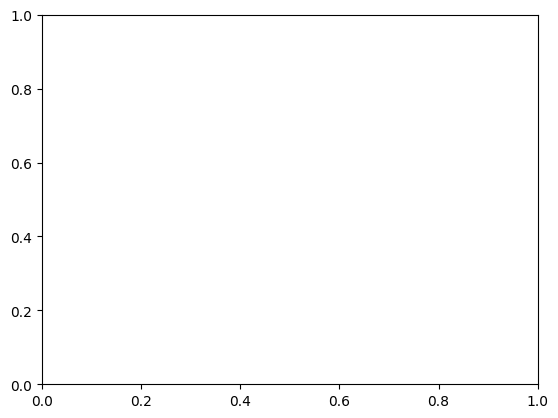

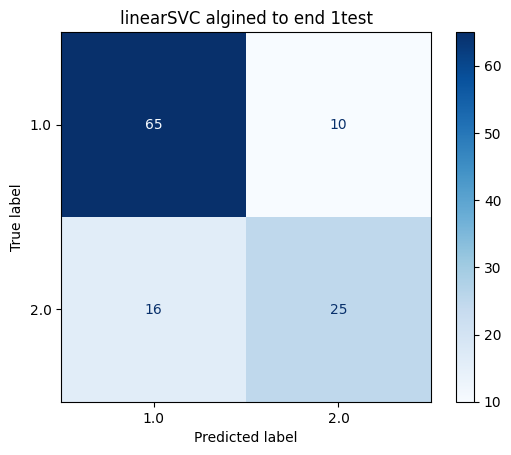

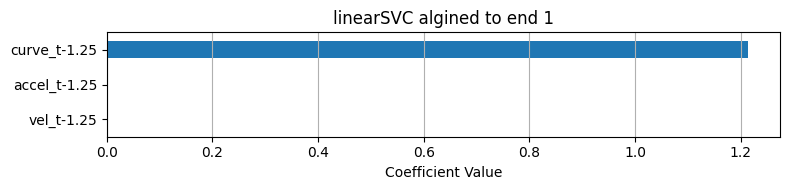

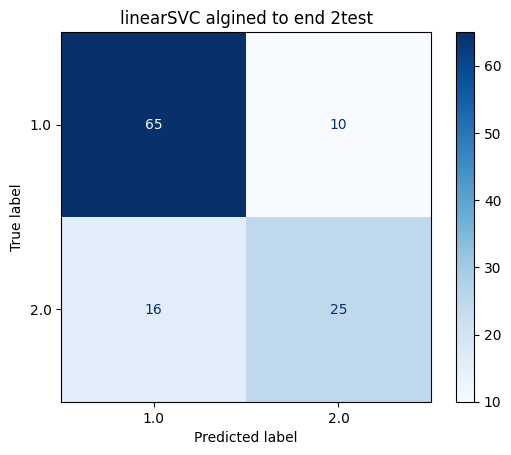

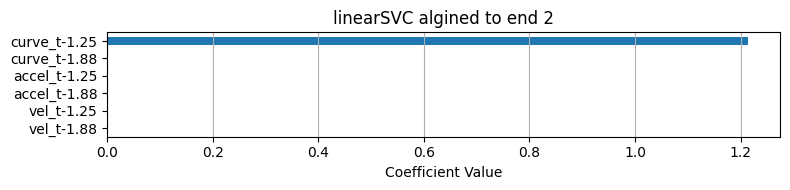

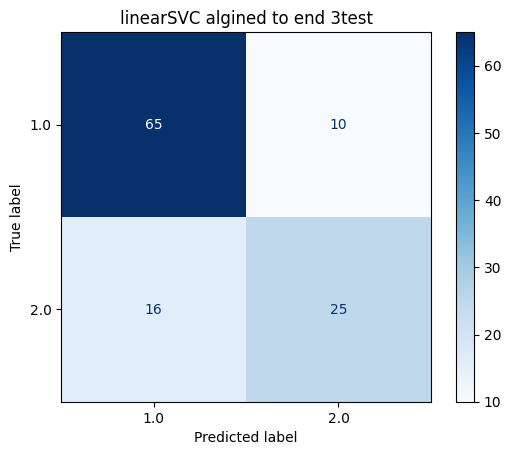

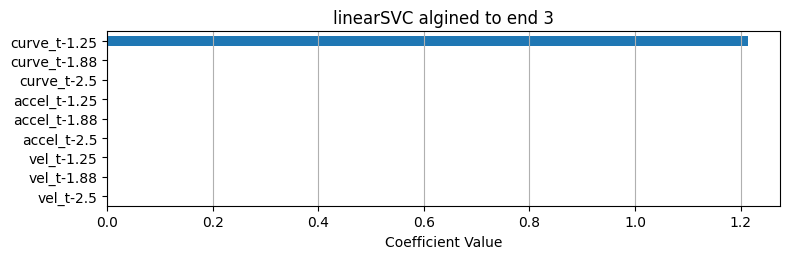

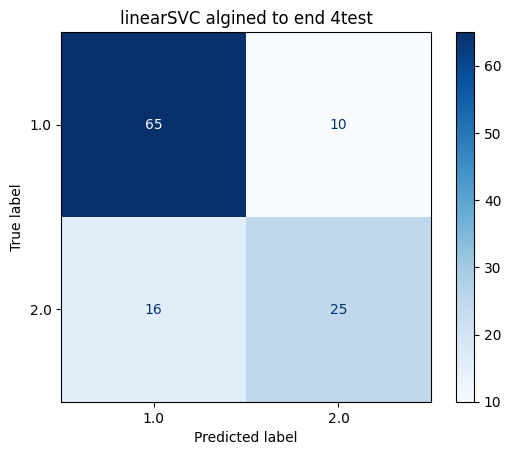

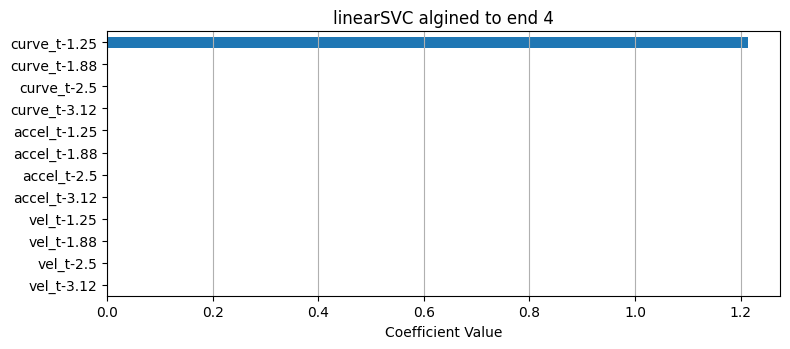

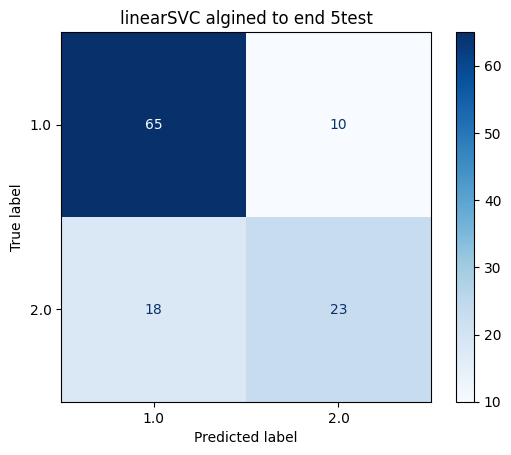

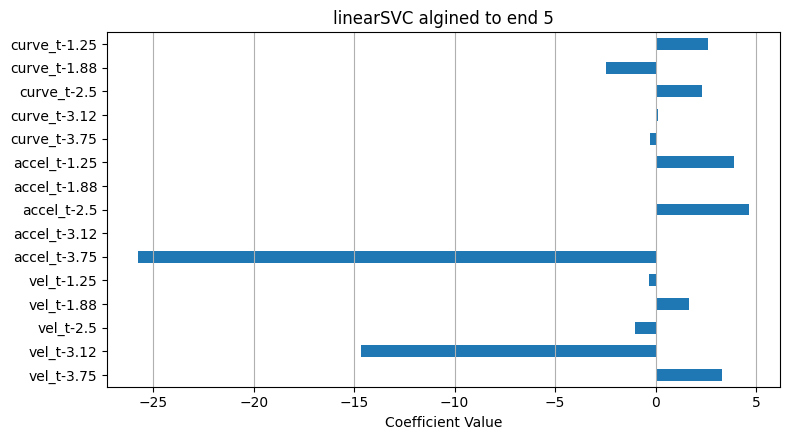

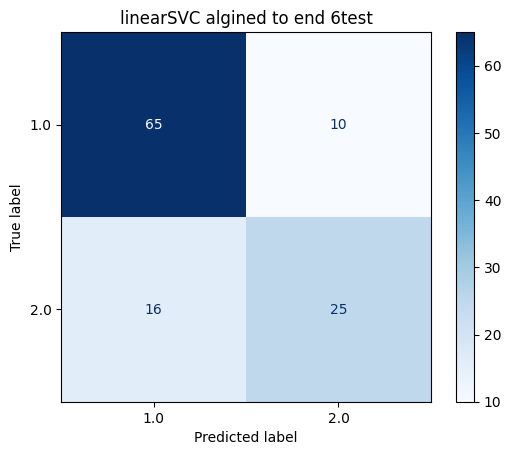

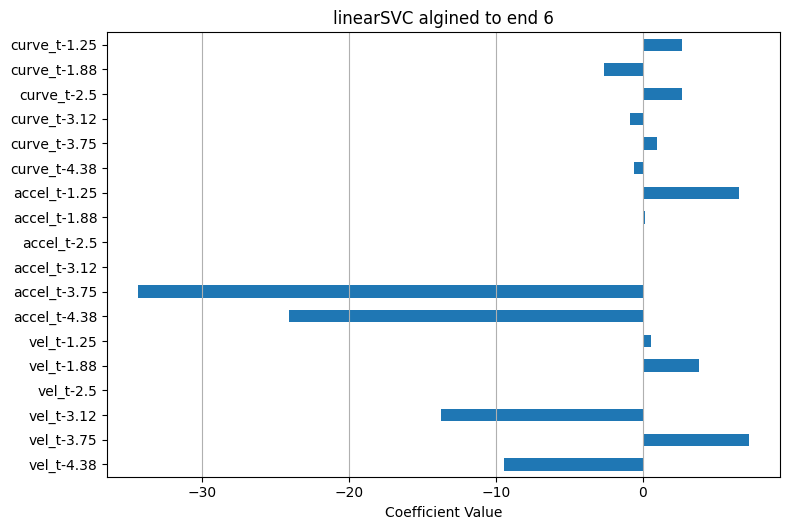

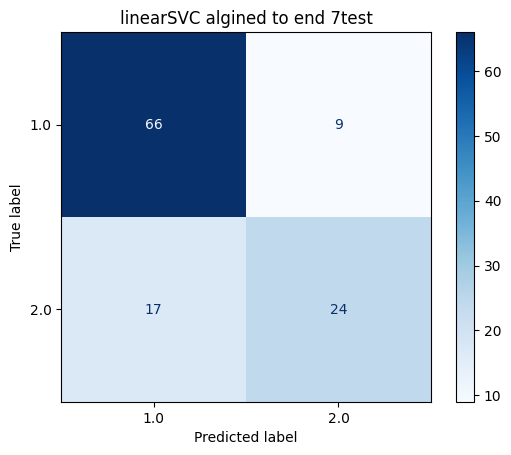

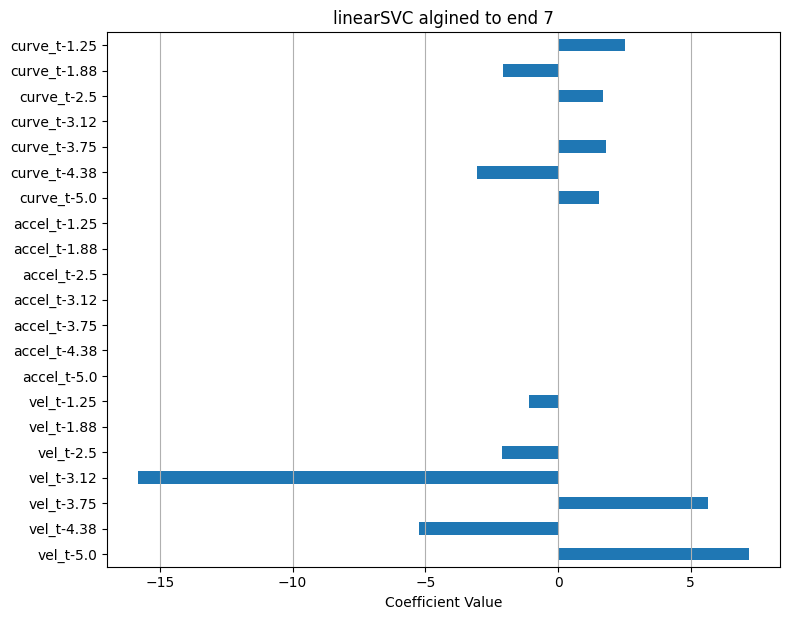

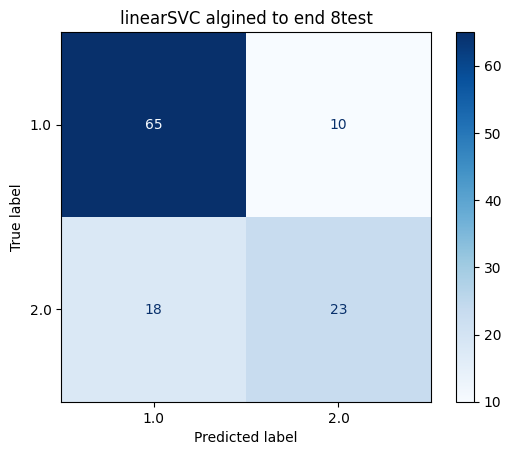

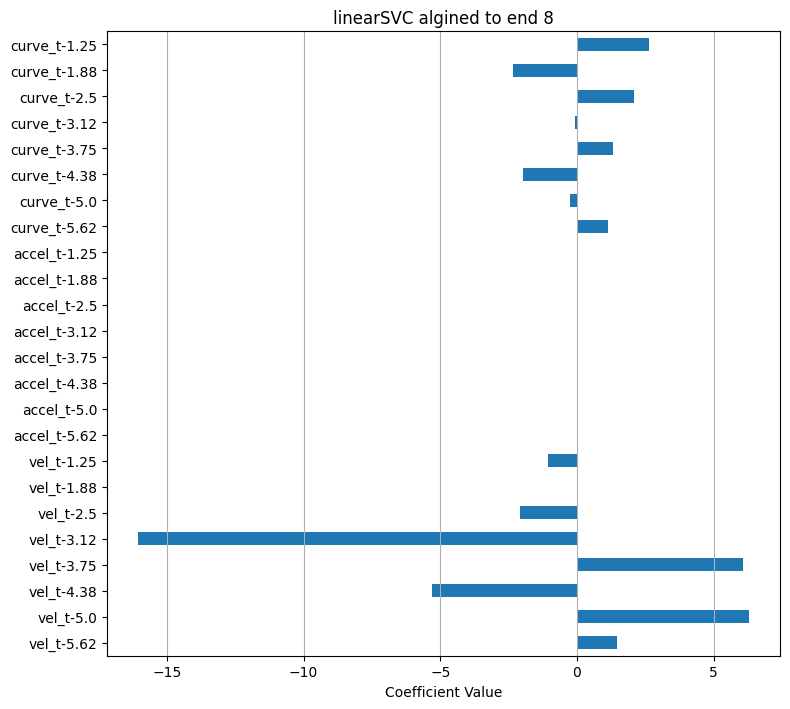

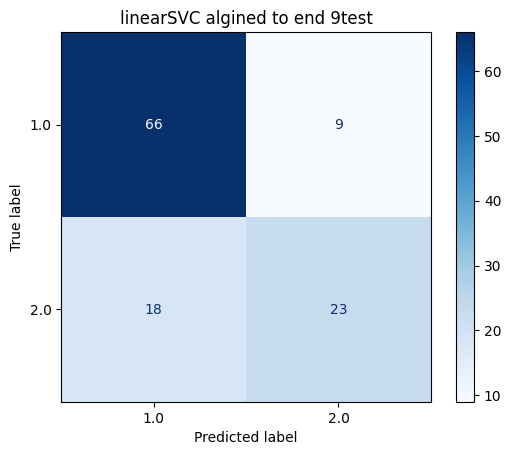

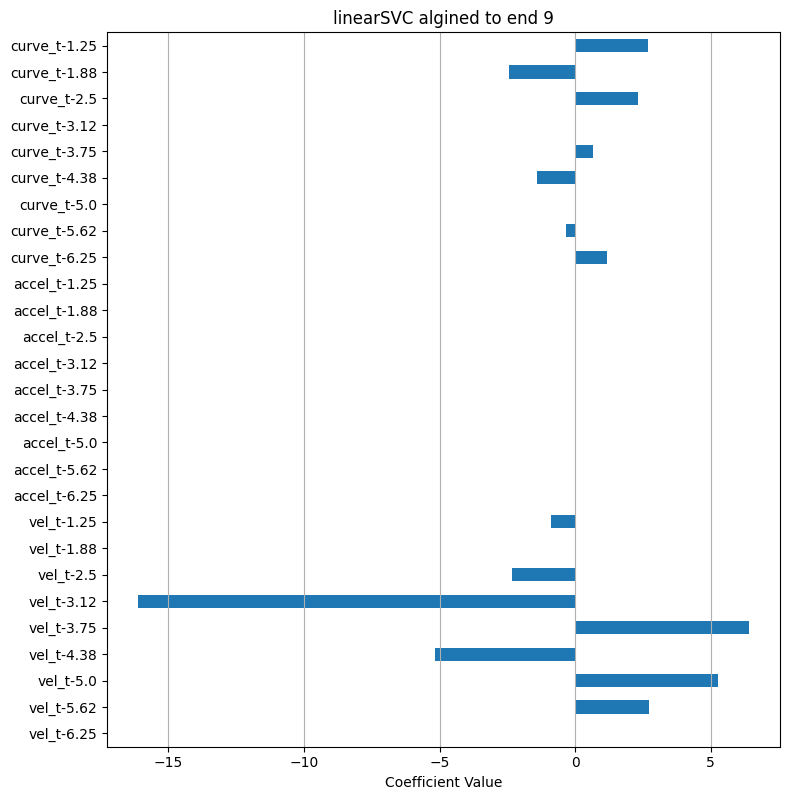

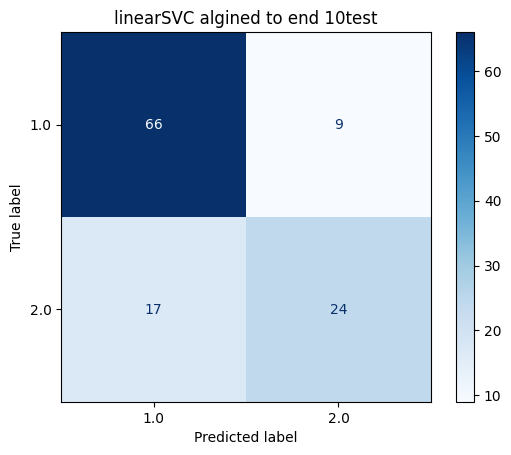

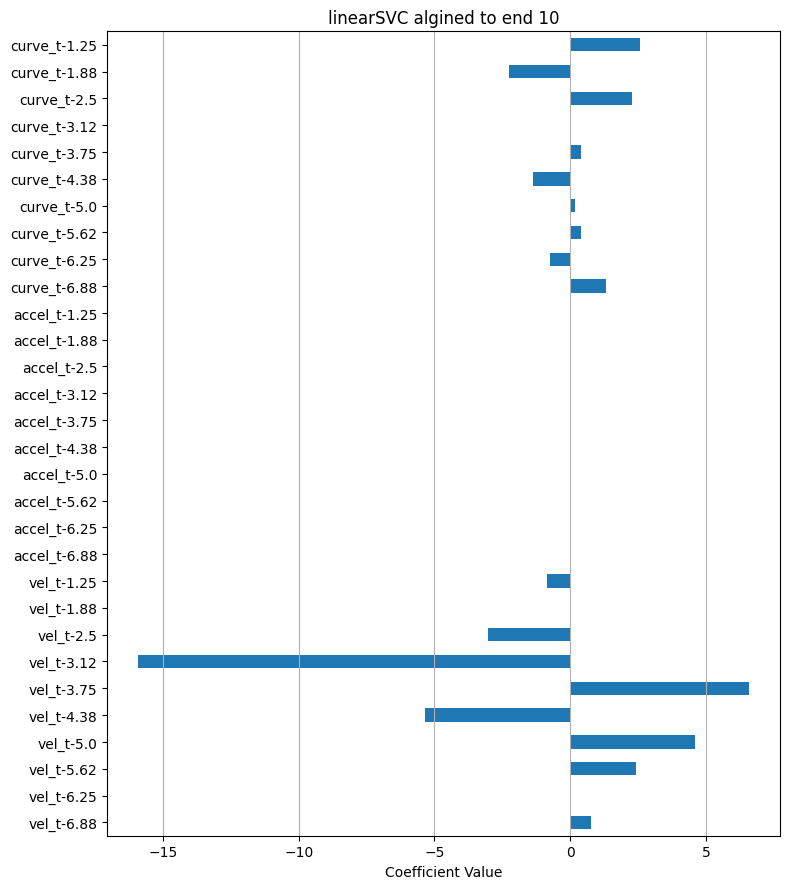

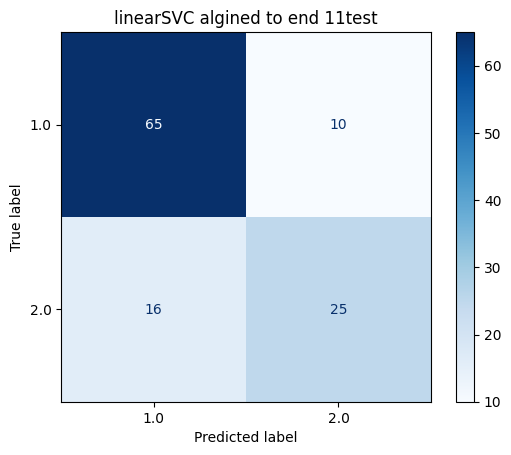

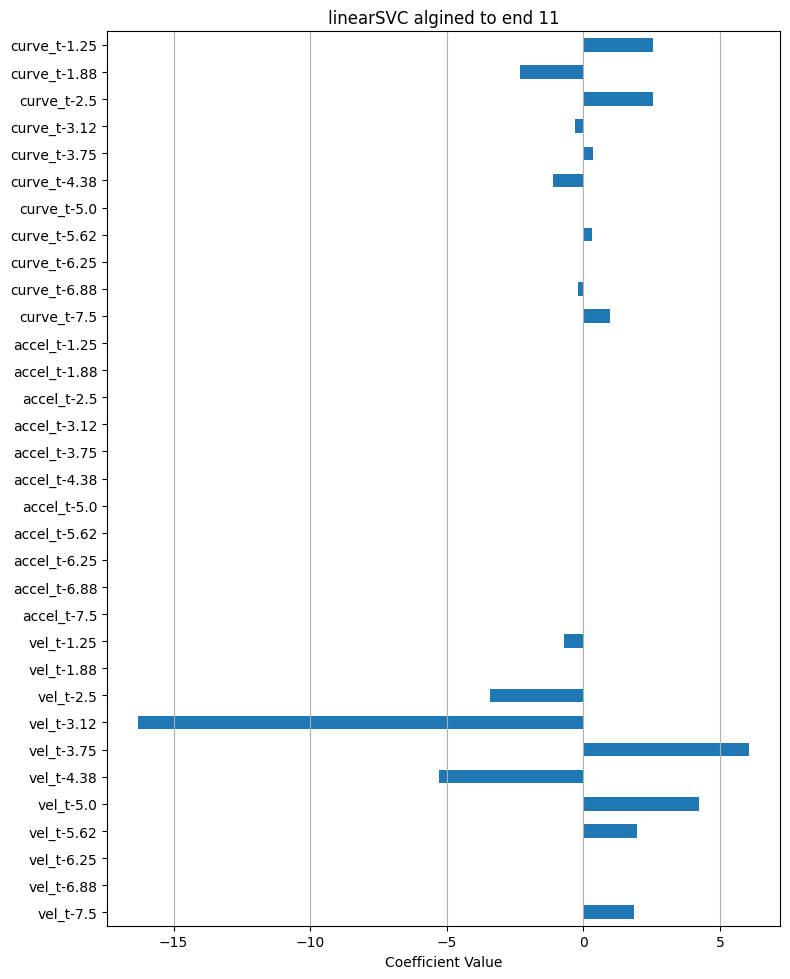

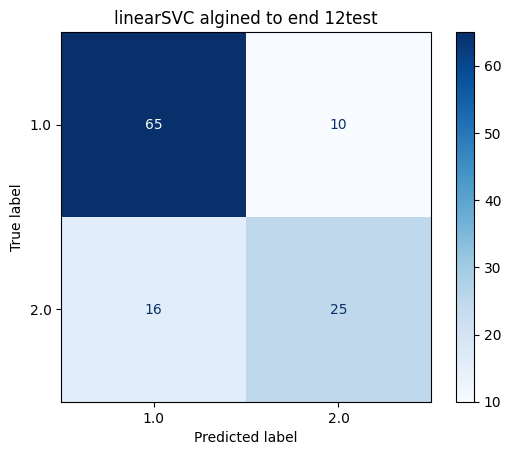

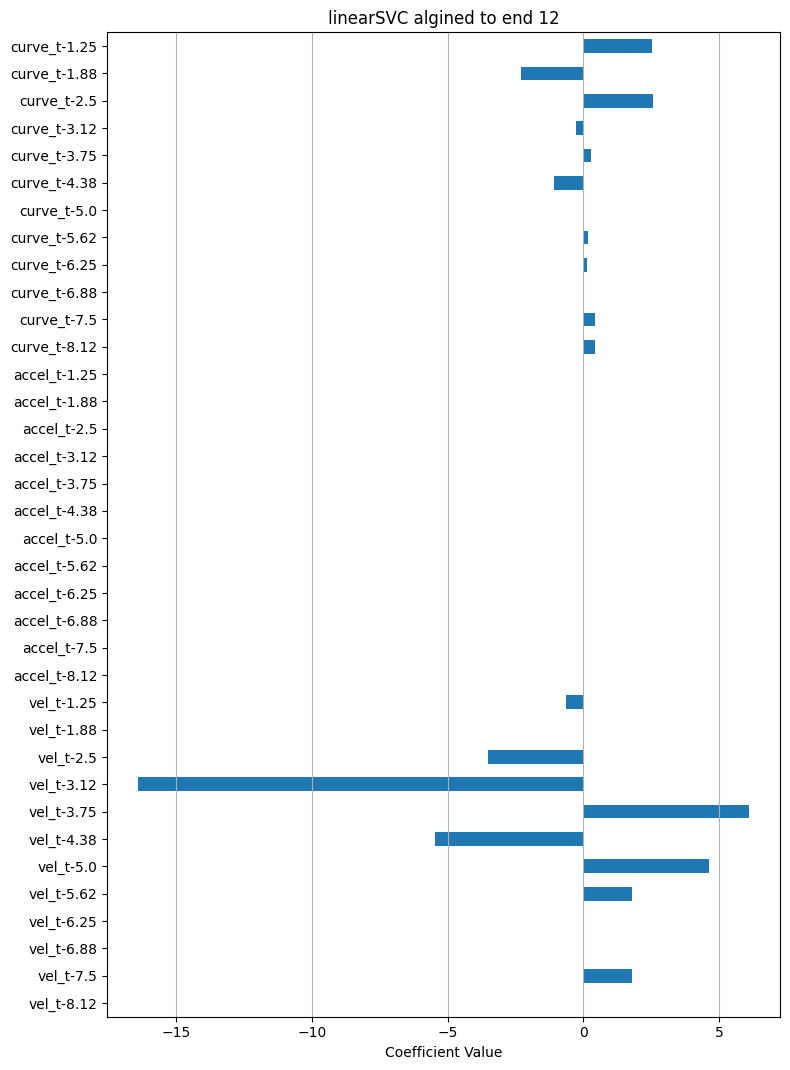

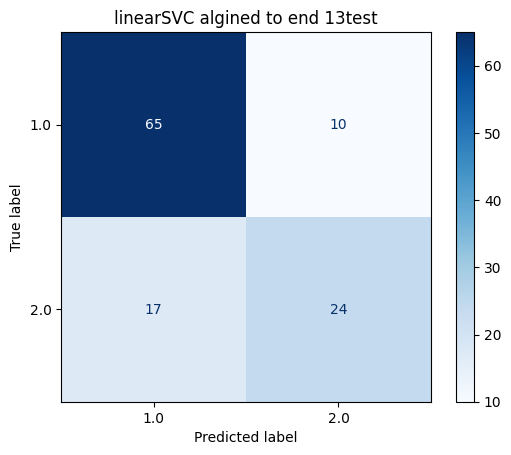

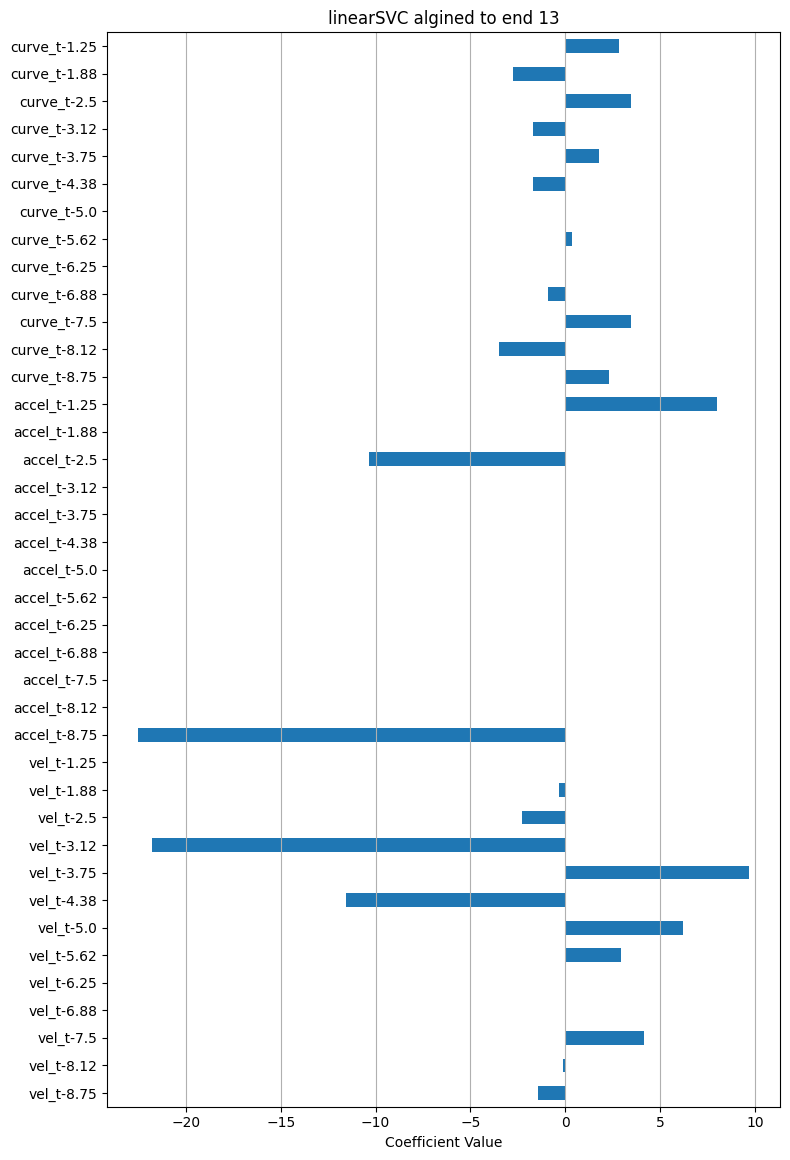

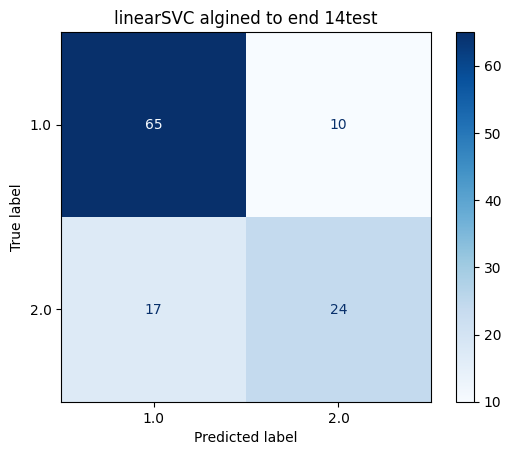

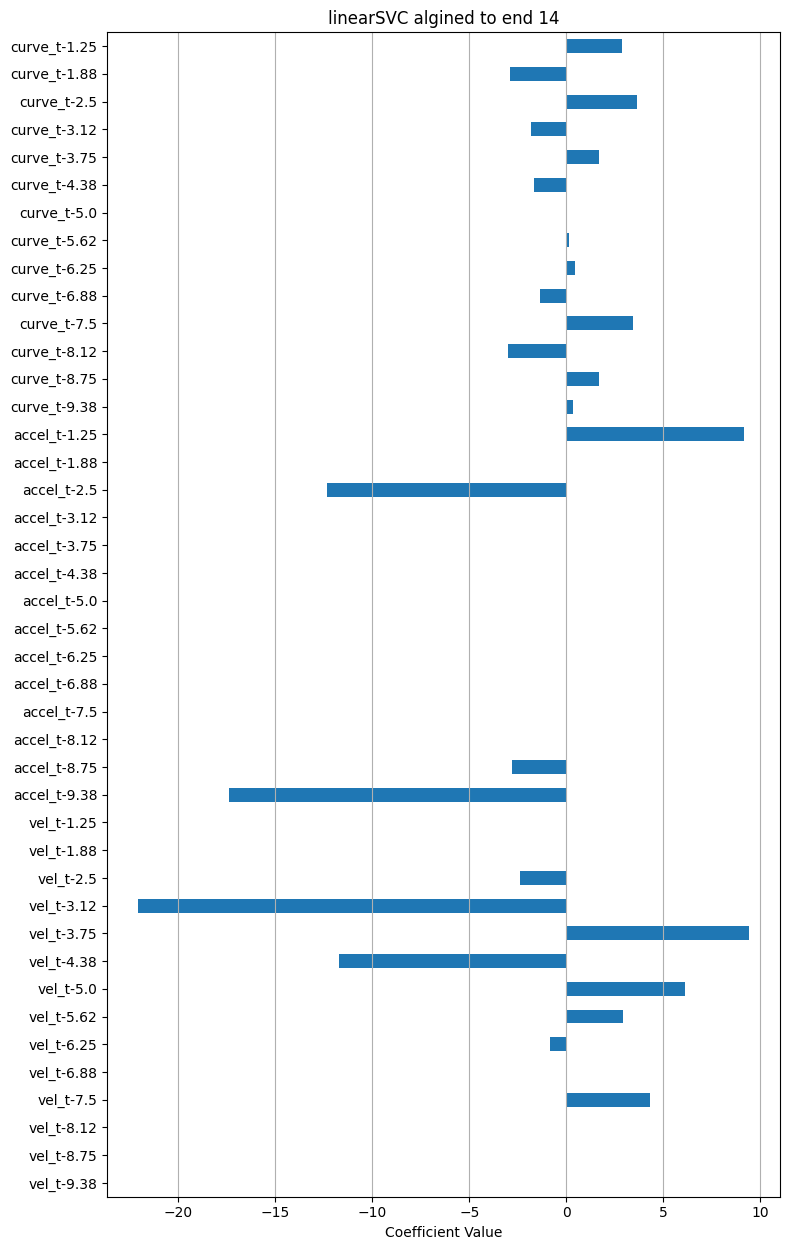

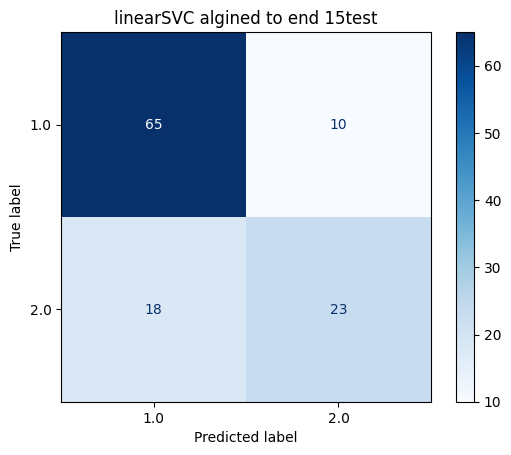

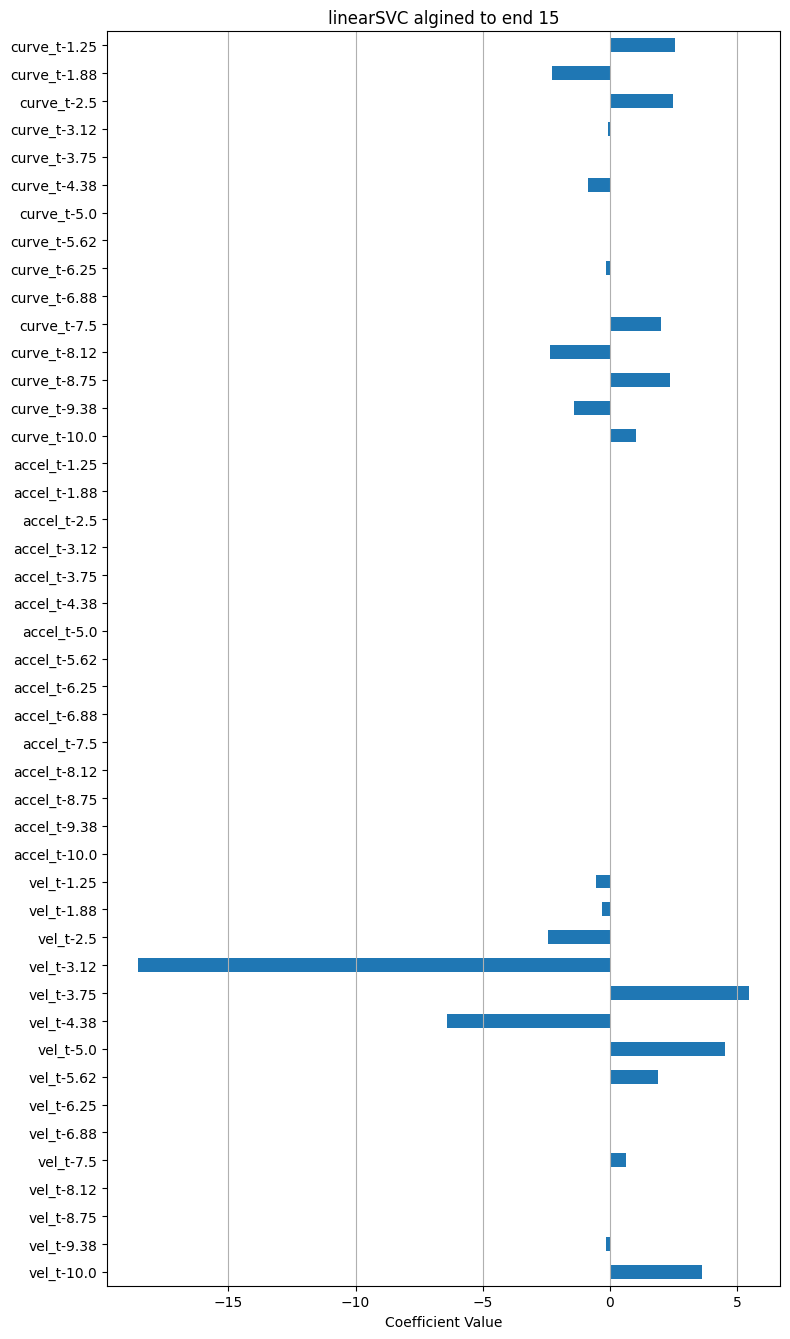

In [ ]:


'''
get max_prior_frames alignment; 

get rev end aligned for bin event mat and feature mat (plot bin mat to make sure ok)
for [1, max_prior_frames] crop tofrom end to start and remove trakc siwth nans 

(also look into getting more priro info..i think will alwsy do tis)

make labels list  
make prediciton  

'''

def prep_FB_inputs_select_features_only_align_to_end(
                    features_list, feature_labels, 
                     n_timesteps, 
                    fps = None
                   ): ###youu coudl combine each row this way.. tbh i think you should... 
    if fps is None: 
        fps = 1

#     X_all_LSTM = []
    # for new_worm_idx in range(len(features_list[0])):
    # X_new_worm = np.stack([feature[new_worm_idx] for feature in features_list
    #                         ], axis=1)  
    # feature_names = np.array([[f"{lbl}_t-{np.round((n_timesteps - t + 1)/fps, 2)}" 
    #                                                     for t in range(n_timesteps)  ]
    #                                                 for lbl in feature_labels ]).flatten()
        
    X_all  = []
    feature_names = []
    n_frames = features_list[0].shape[1]
    for feature_mat, lbl in zip(features_list, feature_labels):
        X_all.append(feature_mat[:, (n_frames-n_timesteps):n_frames])#ntrack, n frame
        feature_names.append([f"{lbl}_t-{np.round((n_timesteps - t + 1)/fps, 2)}" 
                                                        for t in range(n_timesteps) ])

    return np.concatenate(X_all, axis = 1) , np.concatenate(feature_names)


def prep_FB_inputs_select_features_only_align_to_start(
                    features_list, feature_labels, 
                     n_timesteps, 
                    fps = None
                   ): ###youu coudl combine each row this way.. tbh i think you should... 
    if fps is None: 
        fps = 1

#     X_all_LSTM = []
    # for new_worm_idx in range(len(features_list[0])):
    # X_new_worm = np.stack([feature[new_worm_idx] for feature in features_list
    #                         ], axis=1)  
    # feature_names = np.array([[f"{lbl}_t+{np.round((i)/fps, 2)}" 
    #                                                     for i in range(n_timesteps)  ]
    #                                                 for lbl in feature_labels ]).flatten()
        
    X_all  = []
    feature_names = []
    # n_frames = feature_mat.shape[1]
    for feature_mat, lbl in zip(features_list, feature_labels):
        X_all.append(feature_mat[:, 0:n_timesteps])#ntrack, n frame
        print(feature_mat[:, 0:n_timesteps].shape)
        feature_names.append([f"{lbl}_t+{np.round(t/fps, 2)}" 
                                                        for t in range(n_timesteps) ])
    print([i.shape for i in X_all])
    return np.concatenate(X_all, axis = 1) , np.concatenate(feature_names)

from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
import pandas as pd
        
def plot_coeffs(model, feature_names, model_label,  n_time_steps = None, feature_names_ordered = None, xlim = None, coeffs = None):
    if coeffs is None: 
            
        try: 
            
            coeffs = model.coef_
        except: 
            # print(model.coef_.shape)
            coeffs = model.coef_[0]
            # coeffs = pd.Series(model.coef_[0], index=feature_names)
            
        if feature_names_ordered : 
            coeffs = coeffs.reshape(n_time_steps,-1 ).reshape((len(feature_names), -1), order='F').flatten()
            feature_names = feature_names.reshape( n_time_steps, -1).reshape((len(feature_names), -1), order='F').flatten()
    # if coeffs is None: 
    try: 
        coeffs = pd.Series(model.coef_, index=feature_names)
    except:
        coeffs = pd.Series(model.coef_[0], index=feature_names)
        # sort_indices = np.argsort(np.argsort(feature_names_ordered)[np.argsort(feature_names)])
        # coeffs = coeffs[sort_indices]
        # feature_names = feature_names[sort_indices]

    # Filter non-zero coefficients and sort
    # nonzero_coeffs = coeffs[coeffs != 0].sort_values()
    nonzero_coeffs = coeffs

    # Plot
    fig_height = max(2, 0.3 * len(nonzero_coeffs))
    fig, ax = plt.subplots(figsize=(8, fig_height))

    # Plot on ax
    nonzero_coeffs.plot(kind='barh', ax=ax)

    # Labels and formatting
    ax.set_xlabel("Coefficient Value")
    if xlim is not None: 
        
        ax.set_xlim(xlim)
    ax.set_title(f"{model_label} coefficients")
    ax.grid(True, axis='x')

    fig.tight_layout()
    return fig, ax 
    # plt.show()
    
def visualize_model_classification(model, model_label, feature_names, X_train, X_test, y_train, y_test, get_coeffs = True,  feature_names_ordered = None,  xlim = None, coeffs = None):
    
    # model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    disp = ConfusionMatrixDisplay.from_estimator(model, X_test,  y_test, cmap='Blues')
    disp.ax_.set_title(f"{model_label}test")
    if get_coeffs:
        fig, ax = plot_coeffs(model, feature_names, model_label, feature_names_ordered = feature_names_ordered, xlim = xlim, coeffs = coeffs)
        ax.set_title(f"{model_label}")
    return model, y_pred

def fit_eval_linearSVC(X_train, X_test, y_train, y_test):
    
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100]
    }

    model = LinearSVC(penalty='l1', dual=False, max_iter=10000)
    # Grid search
    grid = GridSearchCV(model, param_grid, cv=5, scoring='balanced_accuracy')
    grid.fit(X_train, y_train)
    c = grid.best_params_['C']
    best_model = grid.best_estimator_
    
    y_pred = best_model.predict(X_test)
    score = balanced_accuracy_score(y_test, y_pred)  


    return best_model, y_pred, score

# from predict_latency_prob_from_features_donut import prep_FB_inputs_select_features_only_no_onset, fit_eval_linearSVC, visualize_model_classification

def predict_rev_turn_aligned_to_rev_start(feature_mat,
                                          reor_mat, 
                                          max_prior_frames,  feature_lbls, rev_duration_min = 6,
                                          test_size = 0.3, 
                                            # n_splits = 5, 
                                            # lstm_lag = 0, 
                                            fps = 1.6
                                          
                                            
                        ):
    
    max_prior_frames = min (max_prior_frames, rev_duration_min)
    # state_to_track_start_end_is = get_state_to_track_start_end_is(rev_of_rev_turn_bin_mat, states = [1,2])
    reor_state_to_track_start_end_is = get_state_to_track_start_end_is(reor_mat, states = state_to_label.keys())
    rev_of_rev_turn_track_start_end_is = reor_state_to_track_start_end_is[1]
    pure_rev_track_start_end_is  = reor_state_to_track_start_end_is[2]
    #########
    #########
    # rev_of_rev_turn_track_start_end_is = rev_of_rev_turn_track_start_end_is[:,2] + 3
    # pure_rev_track_start_end_is[:, 2] = pure_rev_track_start_end_is[:, 2] +3
    #########
    #########
    pure_rev_aligned_feature = align_feature_to_rev_start_from_start_end_is(feature_mat,
                                                                     pure_rev_track_start_end_is, 
                                                                     max_prior_frames,
                            
                            rev_duration_min_frames = rev_duration_min, rev_duration_max_frames = np.inf
    )
    
    rev_of_rev_turn_start_aligned_feature = align_feature_to_rev_start_from_start_end_is(feature_mat,
                                                                     rev_of_rev_turn_track_start_end_is, 
                                                                     max_prior_frames,
                            
                            rev_duration_min_frames = rev_duration_min, rev_duration_max_frames = np.inf
    )
    if len(feature_mat.shape) ==2:
        pure_rev_aligned_feature = pure_rev_aligned_feature[:, :, None]
        rev_of_rev_turn_start_aligned_feature = rev_of_rev_turn_start_aligned_feature[:, :, None]
    rev_start_aligned_feature_all = np.concatenate([pure_rev_aligned_feature, rev_of_rev_turn_start_aligned_feature], axis = 0)
    label_all = np.concatenate([np.ones(pure_rev_aligned_feature.shape[0])*1, np.ones(rev_of_rev_turn_start_aligned_feature.shape[0])*2], axis = 0)
    for i in range(1, max_prior_frames+1): 

        
        feature_list = [rev_start_aligned_feature_all[:,:,k] for k in range(rev_start_aligned_feature_all.shape[2])]
        features,feature_names =  prep_FB_inputs_select_features_only_align_to_start(
                    feature_list, feature_lbls, 
                     i, 
                    fps = fps
                   )
        print("features", features.shape)
        print("feature_names", feature_names.shape)
        
        non_nan_tracks = np.argwhere(~np.any(np.isnan(features), axis = 1)).flatten()
        #####have to think about what you do about nans/ mask... coudl jsut use latents..? but accoridng to benent didnt work but didnt use time delay... 
        features = features[non_nan_tracks]
        labels = label_all[non_nan_tracks]
        print("features.shape", features.shape)
        print("labels.shape", labels.shape)
        # features = rev_start_aligned_feature_all[:, :i]
        
        
        # if len(rev_start_aligned_feature.shape) == 2:
        #     feature_lbl = feature_lbls[0]
        #     feature_names = np.array([f"{feature_lbl}_t+{j}" for j in range(i)]).flatten()
            
        # if len(rev_start_aligned_feature.shape) == 3:
        #     n_neurons = feature_mat.shape[2]
        #     n_tracks = features.shape[0]
        #     features = features.reshape((n_tracks, i*n_neurons))###check order!
            
        #     # feature_names = np.array([f"{feature_lbl}_t+{j}" for j in range(i)]).flatten()
        #     feature_names = np.array([[f"{feature_lbl}_t+{j}" for j in range(i)] for lbl in feature_lbls]).flatten()###check order!
        
            
        # labels = label_all
        

        split_idx = 1
        X_train, X_test, y_train, y_test = train_test_split(features, labels,  test_size=test_size, random_state=split_idx)
        
        print(X_train.shape, X_test.shape,y_train.shape, y_test.shape)
        best_model, y_pred, score= fit_eval_linearSVC(X_train, X_test, y_train, y_test)
        visualize_model_classification(best_model, f"linearSVC algined to start {i}", feature_names, X_train, X_test, y_train, y_test,  feature_names_ordered = False
                                #  , coeffs = model.coef_[0]
                                 )
        
def predict_rev_turn_aligned_to_rev_end(feature_mat,
                                          reor_mat, 
                                          max_prior_frames,  feature_lbls, rev_duration_min = 6,
                                          test_size = 0.3, 
                                            # n_splits = 5, 
                                            # lstm_lag = 0, 
                                            fps = 1.6
                                          
                                            
                        ):
    
    max_prior_frames = min (max_prior_frames, rev_duration_min)
    # state_to_track_start_end_is = get_state_to_track_start_end_is(rev_of_rev_turn_bin_mat, states = [1,2])
    reor_state_to_track_start_end_is = get_state_to_track_start_end_is(reor_mat, states = state_to_label.keys())
    rev_of_rev_turn_track_start_end_is = reor_state_to_track_start_end_is[1]
    pure_rev_track_start_end_is  = reor_state_to_track_start_end_is[2]
    # rev_of_rev_turn_track_start_end_is[:,2] = rev_of_rev_turn_track_start_end_is[:,2] + 3
    # pure_rev_track_start_end_is[:, 2] = pure_rev_track_start_end_is[:, 2] +3
    
    pure_rev_aligned_feature = align_feature_to_rev_end_from_start_end_is(feature_mat,
                                                                     pure_rev_track_start_end_is, 
                                                                     max_prior_frames,
                            
                            rev_duration_min_frames = rev_duration_min, rev_duration_max_frames = np.inf
    )
    
    rev_of_rev_turn_aligned_feature = align_feature_to_rev_end_from_start_end_is(feature_mat,
                                                                     rev_of_rev_turn_track_start_end_is, 
                                                                     max_prior_frames,
                            
                            rev_duration_min_frames = rev_duration_min, rev_duration_max_frames = np.inf
    )
    if len(feature_mat.shape) ==2:
        pure_rev_aligned_feature = pure_rev_aligned_feature[:, :, None]
        rev_of_rev_turn_aligned_feature = rev_of_rev_turn_aligned_feature[:, :, None]
    rev_end_aligned_feature_all = np.concatenate([pure_rev_aligned_feature, rev_of_rev_turn_aligned_feature], axis = 0)
    label_all = np.concatenate([np.ones(pure_rev_aligned_feature.shape[0])*1, np.ones(rev_of_rev_turn_aligned_feature.shape[0])*2], axis = 0)
    for i in range(1, max_prior_frames+1): 

        
        feature_list = [rev_end_aligned_feature_all[:,:,k] for k in range(rev_end_aligned_feature_all.shape[2])]
        features,feature_names =  prep_FB_inputs_select_features_only_align_to_end(
                    feature_list, feature_lbls, 
                     i, 
                    fps = fps
                   )
        # print("features", features.shape)
        # print("feature_names", feature_names.shape)
        
        non_nan_tracks = np.argwhere(~np.any(np.isnan(features), axis = 1)).flatten()
        #####have to think about what you do about nans/ mask... coudl jsut use latents..? but accoridng to benent didnt work but didnt use time delay... 
        features = features[non_nan_tracks]
        labels = label_all[non_nan_tracks]

        split_idx = 1
        X_train, X_test, y_train, y_test = train_test_split(features, labels,  test_size=test_size, random_state=split_idx)
        
        print(X_train.shape, X_test.shape,y_train.shape, y_test.shape)
        best_model, y_pred, score= fit_eval_linearSVC(X_train, X_test, y_train, y_test)
        visualize_model_classification(best_model, f"linearSVC algined to end {i}", feature_names, X_train, X_test, y_train, y_test,  feature_names_ordered = False
                                #  , coeffs = model.coef_[0]
                                 )
state_to_label = {1: "rev of rev turn ", 
                  2: "pure rev"}

rev_of_rev_turn_bin_mat, pure_rev_bin_mat, reor_mat = get_reor_mats(z)
reor_state_to_track_start_end_is = get_state_to_track_start_end_is(reor_mat, states = state_to_label.keys())
####
fps = 1.66

max_prior_frames = 20#int(10/fps)
filter_for_rev_only = True


n_pre_frames = 0
dt = 0.6
fig, ax1 = plt.subplots()
feature_lbl = "rev bin"
rev_duration_min_frames = 20
rev_of_rev_turn_to_track_start_end_is = get_state_to_track_start_end_is(rev_of_rev_turn_bin_mat, states = [1])[1]

# features, feature_labels = np.array(Y), neural_labels
features = np.concatenate([velocity_og[:, :, None], acceleration_og[:, :, None], worm_curvature_og[:, :, None]], axis = 2)
feature_labels = ["vel","accel",  "curve"]
# predict_rev_turn_aligned_to_rev_start(features,
#                                           reor_mat, 
#                                           max_prior_frames,  feature_labels, rev_duration_min = 6,
#                                           test_size = 0.3, 
#                                             # n_splits = 5, 
#                                             # lstm_lag = 0, 
#                                             fps = 1.6
                                          
                                            
#                         )


predict_rev_turn_aligned_to_rev_end(features,
                                          reor_mat, 
                                          max_prior_frames,  feature_labels, rev_duration_min = 15,
                                          test_size = 0.3, 
                                            # n_splits = 5, 
                                            # lstm_lag = 0, 
                                            fps = 1.6
                                          
                                            
                        )

In [ ]:
from visualize_donut_time_series_and_states import plot_donut_beh_figs_1
import pickle 
pickle_fname = "/Users/friederikebuck/Downloads/worm notes/processed_checkpts/worm_angles_concat_neural.pickle"
with open(pickle_fname, "rb") as handle:
    worm_angles_concat_neural, worm_radii_concat_neural, model_neural_directed = pickle.load(handle) 
    



pickle_fname = "/Users/friederikebuck/Downloads/worm notes/processed_checkpts/worm_angles_concat_beh.pickle"
with open(pickle_fname, "rb") as handle:
   worm_angles, worm_radii, model_beh_directed =  pickle.load( handle) 
    
from sklearn.decomposition import PCA
from load_and_process_FB_data_fncs_8 import load_data, reformat_data, plot_data,  analyze_data, replace_outliers_exp, reformat_data_1
# experiment = "duty_cycle"
# condition = "exp"
# neuron = "AVA"
# path = "/Users/friederikebuck/beh_analysis_results/csv/_Aim1_AVA_duty_cycle/"


experiment = "duty_cycle"
condition = "exp"
neuron = "AIB"
path = "/Users/friederikebuck/beh_analysis_results/csv/_AIBC-3_Aim1_AIB_duty_cycle/"


# experiment = "duty_cycle"
# condition = "exp"
# neuron = "RIM"
# path = "/Users/friederikebuck/beh_analysis_results/csv/_Aim1_RIM_duty_cycle/"
from compute_donut_utils import fix_signs, compute_phase,compute_radius, extract_rotation_angle, set_seed
from angle.preprocess import prepare_data, split_and_normalize


y = np.array(q_x)
pca = PCA(n_components=9, svd_solver="full")
pca.fit(np.concatenate(q_x[:-2])) #leave out two worms to test generalization
pca.components_ = fix_signs(pca.components_)
pca_x = pca.transform(np.concatenate(q_x))

#instead of training on phase, we'll train on sin and cosine to avoid the jumping between 2pi and 0
thetas = np.array([compute_phase(q_x[i], pca) for i in range(21)])
y_sin = [np.sin(y_i) for y_i in thetas]
y_cos = [np.cos(y_i) for y_i in thetas]

y = np.zeros((21, 1599, 3))
y[:,:,0] = y_sin
y[:,:,1] = y_cos
y[:,:,2] = [compute_radius(q_x[i], pca) for i in range(21)]

rotated_data = extract_rotation_angle(pca_x, n_neighbors=5)

rotated_data2d = rotated_data[:, 1:3]  # Project onto the principal plane
angles = np.arctan2(rotated_data2d[:, 1], rotated_data2d[:, 0])  

n_worms, timepoints = [21, 1599]
# angles = np.radians((270-np.degrees(angles+ np.pi))%360-180)

angles = angles.reshape(n_worms, timepoints)
rotated_data2d = rotated_data2d.reshape(n_worms, timepoints, 2)

y_sin = np.sin(angles)
y_cos = np.cos(angles)
radii = np.sqrt(rotated_data2d[..., 0]**2 + rotated_data2d[..., 1]**2)

y = np.stack([y_sin, y_cos, radii], axis=-1)
y.shape
z_norm = np.array(z, np.float64)

z_norm = np.array(z, np.float64)
velocity -= velocity.mean()
velocity /= velocity.std()
acceleration -= acceleration.mean()
acceleration /= acceleration.std()
worm_curvature -= worm_curvature.mean()
worm_curvature /= worm_curvature.std()
z_norm -= z_norm.mean()
z_norm /= z_norm.std()
z_flat = np.array(z).flatten()
set_seed(42)
normalize=False
T = 5
X_all, y_all = prepare_data([velocity, acceleration, worm_curvature, z_norm], y, T=T, holdout_idxs=[20])
X_train, X_test, y_train, y_test, input_stats = split_and_normalize(X_all, y_all, normalize=normalize) # test here is held-out timepoints of held-in worms


from load_and_process_FB_data_fncs_8 import  causal_moving_average,plot_data,   reformat_data_1, replace_outliers_exp, replace_outliers_neg_post_seperate_and_resample, smooth_trace,replace_outliers_and_resample,resample_binary,   match_cdf 


exp_data = load_data(experiment, condition, neuron, path = path)


stim_exp_vel, stim_exp_acc, stim_exp_curve, stim_exp_rev, stim_exp_pause, stim_exp_turn, stim_exp_body_angle_mag  = replace_outliers_exp(exp_data, exp_data[0].shape)

exp_onsets = plot_data(stim_exp_vel, stim_exp_acc, stim_exp_curve, stim_exp_rev, stim_exp_pause, experiment, fps=6)

stim_resampled_rev, stim_resampled_turn,stim_resampled_features,  stim_smooth_features, stim_matched_features = reformat_data_1(stim_exp_vel, 
                                                                                             stim_exp_acc,
                                                                                             stim_exp_curve,
                                                                                             stim_exp_rev,
                                                                                             stim_exp_turn, 
                                                                                             stim_exp_pause,
                                                                                             z_flat,
                                                                                             velocity, 
                                                                                             acceleration, 
                                                                                             worm_curvature,
                                                                                             plot=True, 
                                                                                             replace_outliers = True, 
                                                                                             sep_pos_neg_resample = True, match_vel_only = True
                                                                                             )

stim_resampled_vel, stim_resampled_acc, stim_resampled_curve = stim_resampled_features
stim_smooth_vel, stim_smooth_acc, stim_smooth_curve = stim_smooth_features
stim_matched_vel, stim_matched_acc, stim_matched_curve = stim_matched_features


onsets = plot_data(stim_matched_vel, stim_matched_acc, stim_matched_curve, stim_resampled_rev, stim_resampled_turn, experiment, fps=1.6, orig = False)
resampled_onsets = onsets

inferred_phases, final_behaviors, final_behaviors_all, inferred_phases_all, inferred_rad_all, behaviors_all, inferred_rad, initial_behaviors, initial_cts_beh, X_all_LSTM = analyze_data(stim_matched_vel,
                                                                                                                                                                                         stim_matched_acc, 
                                                                                                                                                                                         stim_matched_curve, 
                                                                                                                                                                                         stim_resampled_rev, 
                                                                                                                                                                                         stim_resampled_turn, 
                                                                                                                                                                                         onsets, 
                                                                                                                                                                                         model_beh_directed,  
                                                                                                                                                                                         z_norm,
                                                                                                                                                                                         input_stats,  
                                                                                                                                                                                         z,   
                                                                                                                                                                                         lag=16, 
                                                                                                                                                                                         inclusion_thresh = 2, 
                                                                                                                                                                                         model_type="ff", 
                                                                                                                                                                                         remove_revs=False
                                                                                                                                                                                         
                                                                                                                                                                                         )
beh_all_org = (behaviors_all * np.array(z).std())+ np.array(z).mean()
# plot_donut_beh_figs_1(inferred_phases_all,inferred_rad_all,  beh_all_org,

#                          cmap,
#                             n_bins = 10, 
#                          window = 5)


NameError: name 'y' is not defined

In [9]:
state_to_label = {1: "rev of rev turn ", 
                  2: "pure rev"}
beh_mat = np.zeros_like(stim_exp_rev)
beh_mat[stim_exp_rev.astype('bool')] = 1
beh_mat[stim_exp_turn.astype('bool')] = 2
rev_of_rev_turn_bin_mat, pure_rev_bin_mat, reor_mat = get_reor_mats(beh_mat)
reor_state_to_track_start_end_is = get_state_to_track_start_end_is(reor_mat, states = state_to_label.keys())
####
fps = 6

max_prior_frames = 12#int(10/fps)
filter_for_rev_only = True


n_pre_frames = 0
dt = 0.6
fig, ax1 = plt.subplots()
feature_lbl = "rev bin"
rev_duration_min_frames = 12
rev_of_rev_turn_to_track_start_end_is = get_state_to_track_start_end_is(rev_of_rev_turn_bin_mat, states = [1])[1]

# features, feature_labels = np.array(Y), neural_labels
features_list = [stim_exp_vel, stim_exp_acc, stim_exp_curve]
features = np.concatenate([feat[:, :, None] for feat in features_list], axis = 2)
feature_labels = ["vel","accel",  "curve"]
# predict_rev_turn_aligned_to_rev_start(features,
#                                           reor_mat, 
#                                           max_prior_frames,  feature_labels, rev_duration_min = 6,
#                                           test_size = 0.3, 
#                                             # n_splits = 5, 
#                                             # lstm_lag = 0, 
#                                             fps = 1.6
                                          
                                            
#                         )


predict_rev_turn_aligned_to_rev_end(features,
                                          reor_mat, 
                                          max_prior_frames,  feature_labels, rev_duration_min = 15,
                                          test_size = 0.3, 
                                            # n_splits = 5, 
                                            # lstm_lag = 0, 
                                            fps = 1.6
                                          
                                            
                        )

NameError: name 'stim_exp_rev' is not defined